In [28]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import random
import time
import joblib
import os
from utils import render_single, render_multiple, get_dataset_files, extract_random_entries, extract_first_entries, generate_pixel_columns, load_run
from IPython.display import display, Image as IPImage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from itertools import repeat
from sklearn.multiclass import OneVsRestClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
image_gen_params = [
    {
        'magnification': 4,
        'resolution': 32,
        'invert_color': True,
        'stroke_width_scale': 1
    },
    {
        'magnification': 4,
        'resolution': 64,
        'invert_color': True,
        'stroke_width_scale': 3
    },
    {
        'magnification': 2,
        'resolution': 32,
        'invert_color': True,
        'stroke_width_scale': 1
    },
    {
        'magnification': 2,
        'resolution': 64,
        'invert_color': True,
        'stroke_width_scale': 3
    },
    {
        'magnification': 1,
        'resolution': 32,
        'invert_color': True,
        'stroke_width_scale': 1
    },
    {
        'magnification': 1,
        'resolution': 64,
        'invert_color': True,
        'stroke_width_scale': 3
    },
]

entries_per_cat = 1000

files = ['./dataset/clock.ndjson', './dataset/bicycle.ndjson', './dataset/sailboat.ndjson', './dataset/house.ndjson', './dataset/car.ndjson']
data = [extract_first_entries(file, entries_per_cat, recognized=True) for file in files]
flat_data = [item for sublist in data for item in sublist]
df = pd.DataFrame.from_dict(flat_data, orient='columns')
print(f'Loaded {len(df)} entries from {files}')
df = df.sample(len(df))
print('Done shuffling dataset')

Loaded 5000 entries from ['./dataset/clock.ndjson', './dataset/bicycle.ndjson', './dataset/sailboat.ndjson', './dataset/house.ndjson', './dataset/car.ndjson']
Done shuffling dataset


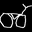

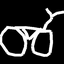

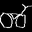

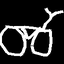

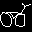

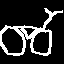

In [30]:
img = df.sample().iloc[0]
for params in image_gen_params:
    display(IPImage(render_single(img['drawing'], **params)))

In [31]:
result = []
for params in image_gen_params:
    result.append({ 'data': generate_pixel_columns(df, **params).reset_index(drop=True) })
    print(f'Done generating pixel columns with params {params}')

Done generating pixel columns with params {'magnification': 4, 'resolution': 32, 'invert_color': True, 'stroke_width_scale': 1}
Done generating pixel columns with params {'magnification': 4, 'resolution': 64, 'invert_color': True, 'stroke_width_scale': 3}
Done generating pixel columns with params {'magnification': 2, 'resolution': 32, 'invert_color': True, 'stroke_width_scale': 1}
Done generating pixel columns with params {'magnification': 2, 'resolution': 64, 'invert_color': True, 'stroke_width_scale': 3}
Done generating pixel columns with params {'magnification': 1, 'resolution': 32, 'invert_color': True, 'stroke_width_scale': 1}
Done generating pixel columns with params {'magnification': 1, 'resolution': 64, 'invert_color': True, 'stroke_width_scale': 3}


In [32]:
for i, entry in enumerate(result):
    data = entry['data']
    print(f'Processing dataset {i + 1}/{len(result)}...')
    train_amt = int(len(data) * .9)

    train = data[:train_amt]
    test = data[train_amt:]

    train = train.reset_index(drop=True)
    test = test.reset_index(drop=True)
    print(f'Done splitting dataset')

    y = train['word'].to_numpy()
    X = train.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word']).to_numpy()
    print("Done generating features and target")

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    pca = PCA(.85)
    X = pca.fit_transform(X)
    print(f'PCA & standardization done. Keeping {pca.n_components_} features')
    entry['train'] = train
    entry['test'] = test
    entry['scaler'] = scaler
    entry['pca'] = pca

Processing dataset 1/6...
Done splitting dataset
Done generating features and target
PCA & standardization done. Keeping 302 features
Processing dataset 2/6...
Done splitting dataset
Done generating features and target
PCA & standardization done. Keeping 294 features
Processing dataset 3/6...
Done splitting dataset
Done generating features and target
PCA & standardization done. Keeping 322 features
Processing dataset 4/6...
Done splitting dataset
Done generating features and target
PCA & standardization done. Keeping 310 features
Processing dataset 5/6...
Done splitting dataset
Done generating features and target
PCA & standardization done. Keeping 479 features
Processing dataset 6/6...
Done splitting dataset
Done generating features and target
PCA & standardization done. Keeping 495 features


In [33]:
start = time.time()
for entry in result:
    train = entry['train']
    test = entry['test']
    pca = entry['pca']
    scaler = entry['scaler']
    classifier = MLPClassifier(hidden_layer_sizes=tuple(repeat(int(pca.n_components_ * 1.2), 3)), solver='lbfgs', alpha=1e-07)
    y = train['word'].to_numpy()
    X = train.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word']).to_numpy()
    X = scaler.transform(X)
    X = pca.transform(X)
    entry['model'] = OneVsRestClassifier(classifier, n_jobs=-1).fit(X, y)
    end = time.time()
    print(f"Done training model in {'{:.2f}'.format(end - start)}s")
    start = end
    

Done training model in 8.97s
Done training model in 10.35s
Done training model in 9.64s
Done training model in 11.14s
Done training model in 23.70s
Done training model in 26.16s


In [34]:
from sklearn.metrics import accuracy_score

for i, entry in enumerate(result):
    scaler = entry['scaler']
    pca = entry['pca']
    model = entry['model']
    test = entry['test'].drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word']).to_numpy()
    test = scaler.transform(test)
    test = pca.transform(test)
    prediction = model.predict(test)

    acc_score = accuracy_score(entry['test']['word'].values.tolist(), prediction)
    print(f"{image_gen_params[i]}, accuracy: {acc_score}")

{'magnification': 4, 'resolution': 32, 'invert_color': True, 'stroke_width_scale': 1}, accuracy: 0.952
{'magnification': 4, 'resolution': 64, 'invert_color': True, 'stroke_width_scale': 3}, accuracy: 0.94
{'magnification': 2, 'resolution': 32, 'invert_color': True, 'stroke_width_scale': 1}, accuracy: 0.934
{'magnification': 2, 'resolution': 64, 'invert_color': True, 'stroke_width_scale': 3}, accuracy: 0.956
{'magnification': 1, 'resolution': 32, 'invert_color': True, 'stroke_width_scale': 1}, accuracy: 0.912
{'magnification': 1, 'resolution': 64, 'invert_color': True, 'stroke_width_scale': 3}, accuracy: 0.93


{'magnification': 4, 'resolution': 32, 'invert_color': True, 'stroke_width_scale': 1}, accuracy: 0.924
{'magnification': 4, 'resolution': 48, 'invert_color': True, 'stroke_width_scale': 2}, accuracy: 0.914
{'magnification': 4, 'resolution': 64, 'invert_color': True, 'stroke_width_scale': 3}, accuracy: 0.922

{'magnification': 4, 'resolution': 32, 'invert_color': True, 'stroke_width_scale': 1}, accuracy: 0.924
{'magnification': 4, 'resolution': 64, 'invert_color': True, 'stroke_width_scale': 3}, accuracy: 0.928
{'magnification': 4, 'resolution': 32, 'invert_color': False, 'stroke_width_scale': 1}, accuracy: 0.928
{'magnification': 4, 'resolution': 64, 'invert_color': False, 'stroke_width_scale': 3}, accuracy: 0.926

{'magnification': 4, 'resolution': 32, 'invert_color': True, 'stroke_width_scale': 1}, accuracy: 0.952
{'magnification': 4, 'resolution': 64, 'invert_color': True, 'stroke_width_scale': 3}, accuracy: 0.94
{'magnification': 2, 'resolution': 32, 'invert_color': True, 'stroke_width_scale': 1}, accuracy: 0.934
{'magnification': 2, 'resolution': 64, 'invert_color': True, 'stroke_width_scale': 3}, accuracy: 0.956
{'magnification': 1, 'resolution': 32, 'invert_color': True, 'stroke_width_scale': 1}, accuracy: 0.912
{'magnification': 1, 'resolution': 64, 'invert_color': True, 'stroke_width_scale': 3}, accuracy: 0.93